# Adversarial Robustness Toolkit

* Documentación: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/
* Código: https://github.com/Trusted-AI/adversarial-robustness-toolbox
* Ejemplos: https://github.com/Trusted-AI/adversarial-robustness-toolbox/tree/main/examples

## Instalación

In [ ]:
!pip install adversarial-robustness-toolbox==1.8.1

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
from art.utils import load_mnist

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

## Cargar datos

In [ ]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [ ]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

print("min_pixel_value:", min_pixel_value)
print("min_pixel_value:", max_pixel_value)

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)
min_pixel_value: 0.0
min_pixel_value: 1.0


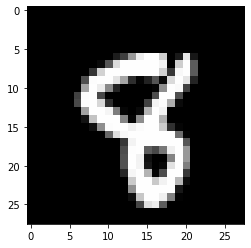

In [ ]:
sample = 34567
plt.imshow(x_train[sample].reshape((28, 28)), cmap='gray', interpolation='none')

## Entrenar modelo

In [ ]:
from art.estimators.classification import KerasClassifier

In [ ]:
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 34s 565us/sample - loss: 0.1569 - accuracy: 0.9508
Epoch 2/3
60000/60000 [==============================] - 5s 77us/sample - loss: 0.0802 - accuracy: 0.9753
Epoch 3/3
60000/60000 [==============================] - 5s 77us/sample - loss: 0.0705 - accuracy: 0.9787


In [ ]:
predictions_test = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {}%".format(accuracy * 100))

Accuracy on test examples: 98.28%


## Generar ejemplos adversarios

In [ ]:
from art.attacks.evasion import FastGradientMethod, SaliencyMapMethod, CarliniL2Method

In [ ]:
attack_fgm = FastGradientMethod(estimator = classifier, eps = 0.2)
x_test_fgm = attack_fgm.generate(x=x_test)

In [ ]:
predictions_test = classifier.predict(x_test_fgm)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test adversarial examples: {0:.2f}%".format(accuracy * 100))

Accuracy on test adversarial examples: 47.07%


In [ ]:
# Ataque no dirigido
best = (100, 0, None, None) # (acc, eps, x_test_fgm, predictions)
for eps in np.arange(0.0, 1.0, 0.1):
  attack_fgm = FastGradientMethod(estimator = classifier, eps = eps)
  x_test_fgm = attack_fgm.generate(x=x_test)
  predictions_test = classifier.predict(x_test_fgm)
  accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  if(accuracy < best[0]):
    best = (accuracy, eps, x_test_fgm, predictions_test)
  print("Accuracy on test adversarial examples: {:.2f}% (eps={:.2f})".format(accuracy * 100, eps))
print("Best results: accuracy: {:.2f}%  eps={:.2f}".format(best[0] * 100, best[1]))

Accuracy on test adversarial examples: 98.28% (eps=0.00)
Accuracy on test adversarial examples: 77.81% (eps=0.10)
Accuracy on test adversarial examples: 47.07% (eps=0.20)
Accuracy on test adversarial examples: 31.44% (eps=0.30)
Accuracy on test adversarial examples: 24.97% (eps=0.40)
Accuracy on test adversarial examples: 21.86% (eps=0.50)
Accuracy on test adversarial examples: 20.06% (eps=0.60)
Accuracy on test adversarial examples: 19.09% (eps=0.70)
Accuracy on test adversarial examples: 18.93% (eps=0.80)
Accuracy on test adversarial examples: 19.50% (eps=0.90)
Best results: accuracy: 18.93%  eps=0.80


In [ ]:
# Ataque dirigido
best_targeted = (100, 0, None, None) # (acc, eps, x_test_fgm, predictions)
for eps in np.arange(0.0, 1.0, 0.1):
  attack_fgm = FastGradientMethod(estimator = classifier, eps = eps, targeted=True)
  x_test_fgm = attack_fgm.generate(x=x_test, y=y_test)
  predictions_test = classifier.predict(x_test_fgm)
  accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  if(accuracy < best_targeted[0]):
    best_targeted = (accuracy, eps, x_test_fgm, predictions_test)
  print("Accuracy on test adversarial examples: {:.2f}% (eps={:.2f})".format(accuracy * 100, eps))
print("Best results (targeted): accuracy: {:.2f}%  eps={:.2f}".format(best_targeted[0] * 100, best_targeted[1]))

Accuracy on test adversarial examples: 98.28% (eps=0.00)
Accuracy on test adversarial examples: 99.86% (eps=0.10)
Accuracy on test adversarial examples: 99.53% (eps=0.20)
Accuracy on test adversarial examples: 97.61% (eps=0.30)
Accuracy on test adversarial examples: 93.78% (eps=0.40)
Accuracy on test adversarial examples: 87.66% (eps=0.50)
Accuracy on test adversarial examples: 78.30% (eps=0.60)
Accuracy on test adversarial examples: 67.88% (eps=0.70)
Accuracy on test adversarial examples: 57.39% (eps=0.80)
Accuracy on test adversarial examples: 49.35% (eps=0.90)
Best results (targeted): accuracy: 49.35%  eps=0.90


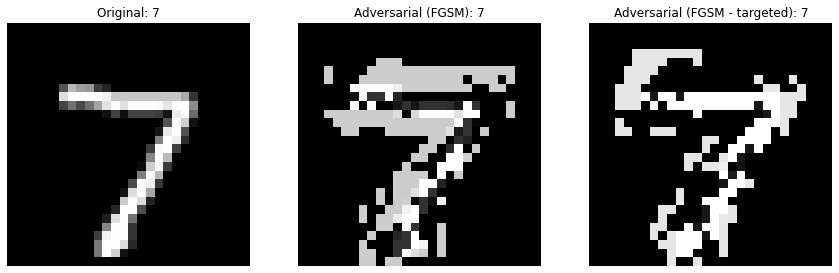

In [ ]:
sample = 0
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(x_test[sample].reshape((28, 28)), cmap='gray', interpolation='none')
ax.set_title("Original: {}".format(np.argmax(y_test[sample])))
ax.axis('off')
ax = fig.add_subplot(1, 4, 2)
ax.imshow(best[2][sample].reshape((28, 28)), cmap='gray', interpolation='none')
ax.set_title("Adversarial (FGSM): {}".format(np.argmax(best[3][sample])))
ax.axis('off')
ax = fig.add_subplot(1, 4, 3)
ax.imshow(best_targeted[2][sample].reshape((28, 28)), cmap='gray', interpolation='none')
ax.set_title("Adversarial (FGSM - targeted): {}".format(np.argmax(best_targeted[3][sample])))
ax.axis('off')
fig.show()

# Otros métodos de ataque

In [ ]:
# Estos métodos tardan bastante tiempo en ejecutar.

# JSMA
# attack_jsma = SaliencyMapMethod(classifier = classifier, theta = 0.1)
# x_test_jsma = attack_jsma.generate(x=x_test)

# Carlini&Wagner
# attack_cw2 = CarliniL2Method(classifier = classifier)
# x_test_cw2 = attack_cw2.generate(x=x_test)

# Entrenamiento adversario

In [ ]:
attack_fgm = FastGradientMethod(estimator = classifier, eps = 0.7)
x_train_fgm = attack_fgm.generate(x=x_train)

In [ ]:
x_train = np.append(x_train, x_train_fgm, axis=0)
y_train = np.append(y_train, y_train, axis=0)

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

Train on 120000 samples
Epoch 1/3
120000/120000 [==============================] - 9s 78us/sample - loss: 0.1726 - accuracy: 0.9474
Epoch 2/3
120000/120000 [==============================] - 10s 79us/sample - loss: 0.1496 - accuracy: 0.9552
Epoch 3/3
120000/120000 [==============================] - 10s 80us/sample - loss: 0.1412 - accuracy: 0.9583


In [ ]:
predictions_test = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {}%".format(accuracy * 100))

predictions_fsm = classifier.predict(x_test_fgm)
accuracy = np.sum(np.argmax(predictions_fsm, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples for JSM attack: {}%".format(accuracy * 100))

Accuracy on test examples: 97.00999999999999%
Accuracy on adversarial test examples for JSM attack: 34.83%


## Entrenamiento adversario de forma nativa

In [ ]:
from art.defences.trainer import AdversarialTrainer

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])

In [ ]:
defence = AdversarialTrainer(classifier=classifier, attacks=attack_fgm, ratio=0.5)

In [ ]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [ ]:
defence.fit(x=x_train, y=y_train, nb_epochs=3)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
predictions_test = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {}%".format(accuracy * 100))

predictions_fgm = defence.predict(x_test_fgm)
accuracy = np.sum(np.argmax(predictions_fgm, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples for FGM attack: {}%".format(accuracy * 100))

Accuracy on test examples: 97.0%
Accuracy on adversarial test examples for FGM attack: 51.23%
